In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os

In [2]:
#Load the dataset
dataset_dir = "quick_draw_dataset"
files = [name for name in os.listdir(dataset_dir) if ".npy" in name]
max_size_per_cl = 1500
draw_class = []

# Evalueate the size of the dataset
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add the new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl] # Take only 10 000 draw
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    # Iter
    it += draws.shape[0]
    t += 1

images = images.astype(np.float32)
    
# Shuffle dataset
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)

print("images.shape", images.shape)
print("targets.shape", targets.shape)

print("images_valid.shape", images_valid.shape)
print("targets_valid.shape", targets_valid.shape)

print(draw_class)


images.shape (10050, 28, 28)
targets.shape (10050,)
images_valid.shape (4950, 28, 28)
targets_valid.shape (4950,)
['book', 'dog', 'face', 'brain', 'The Eiffel Tower', 'eye', 'car', 'chair', 'apple', 'airplane']


<function matplotlib.pyplot.show(*args, **kw)>

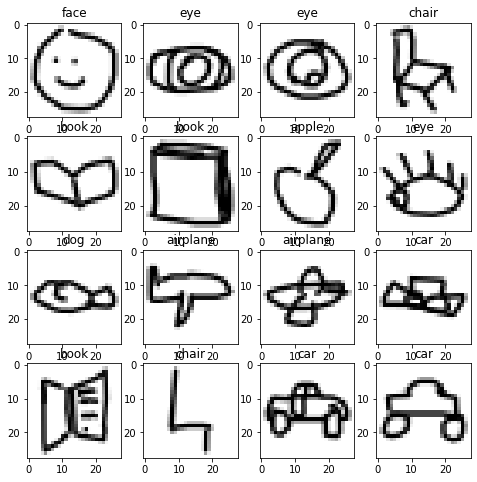

In [3]:
#Show some exemple
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    index = np.random.randint(len(images))
    img = images[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets[index])])
    plt.imshow(img, cmap='gray')
plt.show

In [4]:
scaler = StandardScaler()
scaled_imges = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_imges_valid = scaler.transform(images_valid.reshape(-1, 28*28))
scaled_imges = scaled_imges.reshape(-1, 28, 28, 1)
scaled_imges_valid = scaled_imges_valid.reshape(-1, 28, 28, 1)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_imges, targets))
valid_datset = tf.data.Dataset.from_tensor_slices((scaled_imges_valid, targets_valid))

In [6]:
epoch = 1
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break

(32, 28, 28, 1) (32,)


In [7]:
class ConvModel(tf.keras.Model):

    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name='conv1')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name='conv2')
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name='conv3')
        self.flatten = tf.keras.layers.Flatten(name='Flatten')
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name='d1')
        self.out = tf.keras.layers.Dense(10, activation='softmax', name='output')
    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()
model.predict(scaled_imges[0:1])

array([[0.09023528, 0.10685369, 0.09514645, 0.11794081, 0.10196748,
        0.09077573, 0.10843717, 0.09381972, 0.0945856 , 0.10023803]],
      dtype=float32)

In [8]:
loss_objects = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [9]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [10]:
@tf.function
def train_step(images, targets):
    with tf.GradientTape() as tape:
        prediction = model(images)
        loss = loss_objects(targets, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(targets, prediction)
    

In [11]:
@tf.function
def valid_step(images, targets):
    prediction = model(images)
    t_loss = loss_objects(targets, prediction)
    valid_loss(t_loss)
    valid_accuracy(targets, prediction)

In [ ]:
epoch = 10
batch_size = 32
b = 0
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_datset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 10048/10050, Loss: 0.30110201239585876, Accuracy: 90.75621795654297
Epoch 1, Valid Loss: 0.4738878905773163, Valid Accuracy: 87.37374114990234
 Batch 20128/10050, Loss: 0.15332098305225372, Accuracy: 95.15422821044922
Epoch 2, Valid Loss: 0.6483760476112366, Valid Accuracy: 85.69696807861328
 Batch 30208/10050, Loss: 0.08944037556648254, Accuracy: 96.97512054443366
Epoch 3, Valid Loss: 0.7061994075775146, Valid Accuracy: 86.0
 Batch 40288/10050, Loss: 0.06559745222330093, Accuracy: 97.910446166992191
Epoch 4, Valid Loss: 0.6591557264328003, Valid Accuracy: 87.29293060302734
 Batch 50368/10050, Loss: 0.03317699581384659, Accuracy: 98.875625610351561
Epoch 5, Valid Loss: 0.8831995725631714, Valid Accuracy: 86.60606384277344
 Batch 60448/10050, Loss: 0.02905643731355667, Accuracy: 99.044776916503962
Epoch 6, Valid Loss: 0.851401150226593, Valid Accuracy: 87.01010131835938
 Batch 70528/10050, Loss: 0.023960135877132416, Accuracy: 99.31343078613281
Epoch 7, Valid Loss: 0.885159969329